In [45]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [46]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 80
# BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [47]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)

def get_radnom_normal_indices(dataset, train_and_validation, amount):
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, amount, replace=False))
    return dataset.iloc[random_normal_indices, :].sample(frac=1)

def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [48]:
# Read CSV
#dataset = pd.read_csv(DATASET_NAME)
dataset = pd.read_csv("research/creditcard.csv")

assert not dataset.isnull().values.any()
#dataset['Amount'] = StandardScaler().fit_transform(dataset[['Amount']])
dataset = dataset.drop(['Amount'],axis=1)
#dataset['Hour'] = dataset['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
dataset = dataset.drop(['Time'],axis=1)
NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'
print(dataset.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...         V20       V21       V22  \
0  0.098698  0.363787  0.090794  ...    0.251412 -0.018307  0.277838   
1  0.085102 -0.255425 -0.166974  ...   -0.069083 -0.225775 -0.638672   
2  0.247676 -1.514654  0.207643  ...    0.524980  0.247998  0.771679   
3  0.377436 -1.387024 -0.054952  ...   -0.208038 -0.108300  0.005274   
4 -0.270533  0.817739  0.753074  ...    0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.110474  0.066928  0.128539 -0.189115  0.

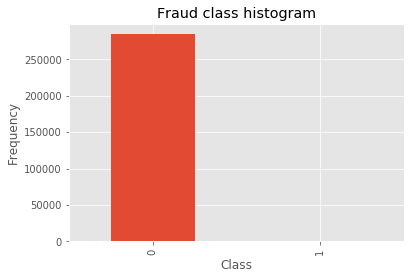

0    284315
1       492
Name: Class, dtype: int64

In [49]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [51]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = split_data(dataset, train_size=0.8)

# export test dataset
test.to_csv("test_dataset.csv", index=False)
print(test.info())
# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56962 entries, 4710 to 57371
Data columns (total 29 columns):
V1       56962 non-null float64
V2       56962 non-null float64
V3       56962 non-null float64
V4       56962 non-null float64
V5       56962 non-null float64
V6       56962 non-null float64
V7       56962 non-null float64
V8       56962 non-null float64
V9       56962 non-null float64
V10      56962 non-null float64
V11      56962 non-null float64
V12      56962 non-null float64
V13      56962 non-null float64
V14      56962 non-null float64
V15      56962 non-null float64
V16      56962 non-null float64
V17      56962 non-null float64
V18      56962 non-null float64
V19      56962 non-null float64
V20      56962 non-null float64
V21      56962 non-null float64
V22      56962 non-null float64
V23      56962 non-null float64
V24      56962 non-null float64
V25      56962 non-null float64
V26      56962 non-null float64
V27      56962 non-null float64
V28      56962 non-null 

None

In [52]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


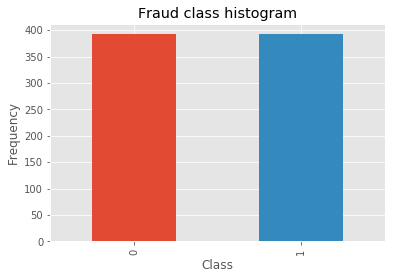

0    392
1    392
Name: Class, dtype: int64

In [53]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [54]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [55]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss, " Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_train, y_train, x_val=None, y_val=None, distinct = 0):
        print(x_train.shape, y_train.shape)
        tr = np.hstack((x_train, y_train))
        tr_f = tr[tr[:, -1] == 1]
        tr_n = tr[tr[:, -1] == 0]
        tr_f_ep = tr_f
        tr_n_ep = tr_n
        tr_score = np.concatenate((tr_f_ep, tr_n[: tr_f.shape[0],:]))
        #print("FIT: tyle jest frauds:", tr_f.shape)
        #print("FIT: tyle jest normals:", tr_n.shape)
        for i in range(self.epochs):
            if(distinct):
                tr_n = np.roll(tr_n, tr_f.shape[0])
                tr_n_ep = tr_n[: tr_f.shape[0],:]
                tr = np.concatenate((tr_f_ep, tr_n_ep))
                x_tr = tr[:,:-1]
                y_tr = tr[:,-1:]
                
            else:
                x_tr = x_train
                y_tr = y_train
                
            # zeby w kazdej epoce byly inne dobre i te same zle ( w jednej walidacji oczywiscie)
            
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.BIG_DELTAS = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(tr_score[:,:-1], tr_score[:,-1:], x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [58]:
KFOLDS = 5

#Create array with only bad transactions for test&validation
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
fraud_indices = dataset.iloc[fraud_indices, :].sample(frac=1)
fraud_indices = fraud_indices.values

kfold_split_frauds = k_fold_split_data(fraud_indices, KFOLDS)
kfold_split_frauds_lens = [len(x) for x in kfold_split_frauds]

normal_total = np.array(train_and_validation[train_and_validation.Class == 0].index)
normal_total_df = dataset.iloc[normal_total, :].sample(frac=1)
normal_total = normal_total_df.values
print(normal_total)

np.random.shuffle(normal_total)
normal_validation_indices = normal_total[:fraud_indices.shape[0], :]
normal_train = normal_total[fraud_indices.shape[0]:, :]

kfold_split_normals = k_fold_split_data(normal_validation_indices, KFOLDS)

print(normal_train.shape, normal_validation_indices.shape, normal_total.shape)

# k-fold validation with k=5
models = []

[[  1.86443983e+00  -5.64606062e-01  -1.04358523e+00 ...,  -6.63762284e-02
   -5.69737884e-02   0.00000000e+00]
 [  1.13545516e+00  -1.97808211e-01   8.20935877e-01 ...,   2.91098528e-04
    1.66160055e-02   0.00000000e+00]
 [ -6.90346947e-01   2.08796487e-01   1.20022917e+00 ...,  -1.73371996e-02
    4.90592556e-03   0.00000000e+00]
 ..., 
 [ -5.09763248e+00   3.10074643e+00  -4.07498711e+00 ...,   2.73729795e-01
   -2.42422806e-02   0.00000000e+00]
 [  2.06437199e+00   1.80583433e-01  -1.68604487e+00 ...,  -5.67301776e-02
   -2.98126776e-02   0.00000000e+00]
 [ -5.82556517e-01   9.00714068e-01   3.29844004e+00 ...,   1.49414589e-01
    9.02674228e-02   0.00000000e+00]]

(227061, 29)

(392, 29)

(227453, 29)

313

(25353, 28)

(25353, 1)

Loss: 

0.545937267161

 Accuracy: 

0.24121405750798722

Loss: 

0.543537591116

 Accuracy: 

0.24281150159744408

Loss: 

0.539511055937

 Accuracy: 

0.24121405750798722

Loss: 

0.533507586956

 Accuracy: 

0.24600638977635783

Loss: 

0.524953869305

 Accuracy: 

0.2523961661341853

Loss: 

0.513367136119

 Accuracy: 

0.24920127795527156

Loss: 

0.49769771751

 Accuracy: 

0.25559105431309903

Loss: 

0.476561338854

 Accuracy: 

0.26357827476038337

Loss: 

0.447370381829

 Accuracy: 

0.2939297124600639

Loss: 

0.403924287002

 Accuracy: 

0.31150159744408945

Loss: 

0.33519584674

 Accuracy: 

0.38977635782747605

Loss: 

0.267406349987

 Accuracy: 

0.4936102236421725

Loss: 

0.232588645896

 Accuracy: 

0.5431309904153354

Loss: 

0.219914736894

 Accuracy: 

0.560702875399361

Loss: 

0.218331312394

 Accuracy: 

0.5559105431309904

Loss: 

0.220178225256

 Accuracy: 

0.5511182108626198

Loss: 

0.222964704174

 Accuracy: 

0.5463258785942492

Loss: 

0.226108099755

 Accuracy: 

0.5447284345047924

Loss: 

0.229227083505

 Accuracy: 

0.5415335463258786

Loss: 

0.232154408498

 Accuracy: 

0.5383386581469649

Loss: 

0.234559175032

 Accuracy: 

0.536741214057508

Loss: 

0.236331685315

 Accuracy: 

0.5415335463258786

Loss: 

0.23750807499

 Accuracy: 

0.5431309904153354

Loss: 

0.238120874223

 Accuracy: 

0.5431309904153354

Loss: 

0.238068284715

 Accuracy: 

0.5447284345047924

Loss: 

0.237374677099

 Accuracy: 

0.547923322683706

Loss: 

0.236174060923

 Accuracy: 

0.5543130990415336

Loss: 

0.234348372351

 Accuracy: 

0.5543130990415336

Loss: 

0.231833990038

 Accuracy: 

0.5559105431309904

Loss: 

0.228653466507

 Accuracy: 

0.5559105431309904

Loss: 

0.224855057807

 Accuracy: 

0.560702875399361

Loss: 

0.220493658435

 Accuracy: 

0.5718849840255591

Loss: 

0.215615628807

 Accuracy: 

0.5862619808306709

Loss: 

0.210078442942

 Accuracy: 

0.5926517571884984

Loss: 

0.203911039532

 Accuracy: 

0.6038338658146964

Loss: 

0.197253002865

 Accuracy: 

0.6166134185303515

Loss: 

0.190097583981

 Accuracy: 

0.6309904153354633

Loss: 

0.182532570948

 Accuracy: 

0.6485623003194888

Loss: 

0.174682753944

 Accuracy: 

0.6853035143769968

Loss: 

0.166536739243

 Accuracy: 

0.7172523961661342

Loss: 

0.158185004235

 Accuracy: 

0.7380191693290735

Loss: 

0.149713879663

 Accuracy: 

0.7603833865814696

Loss: 

0.141238202188

 Accuracy: 

0.7875399361022364

Loss: 

0.132729030597

 Accuracy: 

0.8130990415335463

Loss: 

0.124500084015

 Accuracy: 

0.8354632587859425

Loss: 

0.116476005267

 Accuracy: 

0.8482428115015974

Loss: 

0.108886511722

 Accuracy: 

0.8562300319488818

Loss: 

0.101730571502

 Accuracy: 

0.8706070287539937

Loss: 

0.0950127785534

 Accuracy: 

0.8769968051118211

Loss: 

0.0888664178909

 Accuracy: 

0.889776357827476

Loss: 

0.0832168755564

 Accuracy: 

0.9009584664536742

Loss: 

0.078105508476

 Accuracy: 

0.9137380191693291

Loss: 

0.073505540101

 Accuracy: 

0.9137380191693291

Loss: 

0.0694516992707

 Accuracy: 

0.9185303514376997

Loss: 

0.0658939442096

 Accuracy: 

0.9249201277955271

Loss: 

0.0627827405485

 Accuracy: 

0.9281150159744409

Loss: 

0.0600935516413

 Accuracy: 

0.9313099041533547

Loss: 

0.0577988072256

 Accuracy: 

0.9361022364217252

Loss: 

0.055865753715

 Accuracy: 

0.9376996805111821

Loss: 

0.054264518912

 Accuracy: 

0.9376996805111821

Loss: 

0.0529612743743

 Accuracy: 

0.9376996805111821

Loss: 

0.0519307814656

 Accuracy: 

0.939297124600639

Loss: 

0.0511379608174

 Accuracy: 

0.939297124600639

Loss: 

0.0505568132032

 Accuracy: 

0.9376996805111821

Loss: 

0.0501410345055

 Accuracy: 

0.9361022364217252

Loss: 

0.0498489745566

 Accuracy: 

0.9376996805111821

Loss: 

0.049642636439

 Accuracy: 

0.9408945686900958

Loss: 

0.0494995504809

 Accuracy: 

0.9408945686900958

Loss: 

0.0494084177305

 Accuracy: 

0.9408945686900958

Loss: 

0.0493686370591

 Accuracy: 

0.9440894568690096

Loss: 

0.0493800338412

 Accuracy: 

0.9440894568690096

Loss: 

0.0494440631776

 Accuracy: 

0.9440894568690096

Loss: 

0.0495594413933

 Accuracy: 

0.9456869009584664

Loss: 

0.0497242440976

 Accuracy: 

0.9472843450479234

Loss: 

0.0499347458457

 Accuracy: 

0.9440894568690096

Loss: 

0.0501903765142

 Accuracy: 

0.9408945686900958

Loss: 

0.0504847199716

 Accuracy: 

0.939297124600639

Loss: 

0.0508119186591

 Accuracy: 

0.939297124600639

Loss: 

0.0511671773159

 Accuracy: 

0.939297124600639

Loss: 

0.0515452736609

 Accuracy: 

0.939297124600639


Validation dataset evaluation:

Loss: 

0.0716474136091

Accuracy: 

0.9177215189873418

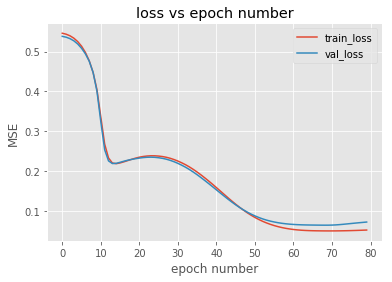

313

(25353, 28)

(25353, 1)

Loss: 

0.435191238332

 Accuracy: 

0.36421725239616615

Loss: 

0.411755718958

 Accuracy: 

0.36900958466453676

Loss: 

0.364758396051

 Accuracy: 

0.39456869009584666

Loss: 

0.293245767678

 Accuracy: 

0.5

Loss: 

0.236087703102

 Accuracy: 

0.6054313099041534

Loss: 

0.209980450354

 Accuracy: 

0.6549520766773163

Loss: 

0.200695354339

 Accuracy: 

0.6613418530351438

Loss: 

0.199670792993

 Accuracy: 

0.6501597444089456

Loss: 

0.202395804511

 Accuracy: 

0.6533546325878594

Loss: 

0.20656369806

 Accuracy: 

0.6405750798722045

Loss: 

0.211098663827

 Accuracy: 

0.634185303514377

Loss: 

0.215547956563

 Accuracy: 

0.6277955271565495

Loss: 

0.219631317996

 Accuracy: 

0.6166134185303515

Loss: 

0.223284967504

 Accuracy: 

0.6118210862619808

Loss: 

0.226464325892

 Accuracy: 

0.6054313099041534

Loss: 

0.229148388937

 Accuracy: 

0.6054313099041534

Loss: 

0.231272965147

 Accuracy: 

0.6006389776357828

Loss: 

0.232803866285

 Accuracy: 

0.6006389776357828

Loss: 

0.233693491969

 Accuracy: 

0.597444089456869

Loss: 

0.234123124997

 Accuracy: 

0.5958466453674122

Loss: 

0.234001266102

 Accuracy: 

0.5990415335463258

Loss: 

0.233252847489

 Accuracy: 

0.6006389776357828

Loss: 

0.231858871547

 Accuracy: 

0.6038338658146964

Loss: 

0.229887554325

 Accuracy: 

0.6038338658146964

Loss: 

0.227319076206

 Accuracy: 

0.6070287539936102

Loss: 

0.224116459367

 Accuracy: 

0.6118210862619808

Loss: 

0.220392072909

 Accuracy: 

0.6198083067092651

Loss: 

0.216144507626

 Accuracy: 

0.6277955271565495

Loss: 

0.211370135905

 Accuracy: 

0.6389776357827476

Loss: 

0.206177558172

 Accuracy: 

0.6517571884984026

Loss: 

0.200586613523

 Accuracy: 

0.6629392971246006

Loss: 

0.194609609238

 Accuracy: 

0.6757188498402555

Loss: 

0.188233225084

 Accuracy: 

0.6900958466453674

Loss: 

0.181689071368

 Accuracy: 

0.7044728434504792

Loss: 

0.17480474834

 Accuracy: 

0.7140575079872205

Loss: 

0.167618723698

 Accuracy: 

0.7380191693290735

Loss: 

0.160337967356

 Accuracy: 

0.7619808306709265

Loss: 

0.152935996323

 Accuracy: 

0.7843450479233227

Loss: 

0.145528555868

 Accuracy: 

0.8003194888178914

Loss: 

0.137911092834

 Accuracy: 

0.8067092651757188

Loss: 

0.13040286666

 Accuracy: 

0.8258785942492013

Loss: 

0.123000660172

 Accuracy: 

0.8370607028753994

Loss: 

0.115843948388

 Accuracy: 

0.8498402555910544

Loss: 

0.109072102339

 Accuracy: 

0.8610223642172524

Loss: 

0.102643344872

 Accuracy: 

0.8578274760383386

Loss: 

0.0965844367794

 Accuracy: 

0.8610223642172524

Loss: 

0.0909723117599

 Accuracy: 

0.8769968051118211

Loss: 

0.0857894313747

 Accuracy: 

0.8833865814696485

Loss: 

0.0810412984965

 Accuracy: 

0.8929712460063898

Loss: 

0.0767515289951

 Accuracy: 

0.902555910543131

Loss: 

0.0729005208544

 Accuracy: 

0.9105431309904153

Loss: 

0.0695211840871

 Accuracy: 

0.9121405750798722

Loss: 

0.0665957694732

 Accuracy: 

0.9121405750798722

Loss: 

0.0641193863965

 Accuracy: 

0.9169329073482428

Loss: 

0.0620794536876

 Accuracy: 

0.9153354632587859

Loss: 

0.0604674757943

 Accuracy: 

0.9201277955271565

Loss: 

0.0592595022328

 Accuracy: 

0.9249201277955271

Loss: 

0.0584189343505

 Accuracy: 

0.9265175718849841

Loss: 

0.0578867680528

 Accuracy: 

0.9281150159744409

Loss: 

0.0576024389328

 Accuracy: 

0.9297124600638977

Loss: 

0.0575154274646

 Accuracy: 

0.9313099041533547

Loss: 

0.0575966880704

 Accuracy: 

0.9313099041533547

Loss: 

0.0578285740912

 Accuracy: 

0.9313099041533547

Loss: 

0.0582045022305

 Accuracy: 

0.9297124600638977

Loss: 

0.0587016517162

 Accuracy: 

0.9281150159744409

Loss: 

0.059314753352

 Accuracy: 

0.9265175718849841

Loss: 

0.060024729446

 Accuracy: 

0.9249201277955271

Loss: 

0.0608107016865

 Accuracy: 

0.9265175718849841

Loss: 

0.0616664239373

 Accuracy: 

0.9249201277955271

Loss: 

0.0625731511396

 Accuracy: 

0.9249201277955271

Loss: 

0.0635127360577

 Accuracy: 

0.9217252396166135

Loss: 

0.0644833819073

 Accuracy: 

0.9217252396166135

Loss: 

0.0654624073449

 Accuracy: 

0.9217252396166135

Loss: 

0.0664337472932

 Accuracy: 

0.9217252396166135

Loss: 

0.0673885647421

 Accuracy: 

0.9185303514376997

Loss: 

0.0683276063735

 Accuracy: 

0.9185303514376997

Loss: 

0.0692457284636

 Accuracy: 

0.9185303514376997

Loss: 

0.0701213909539

 Accuracy: 

0.9153354632587859

Loss: 

0.070952150685

 Accuracy: 

0.9137380191693291

Loss: 

0.0717380876247

 Accuracy: 

0.9137380191693291


Validation dataset evaluation:

Loss: 

0.0753471754727

Accuracy: 

0.9113924050632911

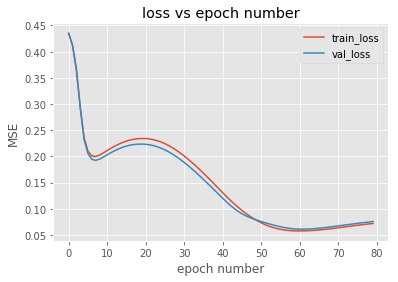

314

(25434, 28)

(25434, 1)

Loss: 

0.570665635953

 Accuracy: 

0.2659235668789809

Loss: 

0.569921310956

 Accuracy: 

0.267515923566879

Loss: 

0.568846976515

 Accuracy: 

0.27070063694267515

Loss: 

0.567456549873

 Accuracy: 

0.2786624203821656

Loss: 

0.565724226017

 Accuracy: 

0.2802547770700637

Loss: 

0.563720805808

 Accuracy: 

0.28343949044585987

Loss: 

0.561406321337

 Accuracy: 

0.2914012738853503

Loss: 

0.558816765298

 Accuracy: 

0.2945859872611465

Loss: 

0.555899332763

 Accuracy: 

0.29777070063694266

Loss: 

0.552670116542

 Accuracy: 

0.30254777070063693

Loss: 

0.549133211745

 Accuracy: 

0.3089171974522293

Loss: 

0.545220956372

 Accuracy: 

0.31687898089171973

Loss: 

0.540952734051

 Accuracy: 

0.32643312101910826

Loss: 

0.536332648482

 Accuracy: 

0.3343949044585987

Loss: 

0.531329994793

 Accuracy: 

0.3487261146496815

Loss: 

0.525880272121

 Accuracy: 

0.3630573248407643

Loss: 

0.519884542539

 Accuracy: 

0.3662420382165605

Loss: 

0.513209951943

 Accuracy: 

0.38057324840764334

Loss: 

0.505676113179

 Accuracy: 

0.39012738853503187

Loss: 

0.496956828872

 Accuracy: 

0.3964968152866242

Loss: 

0.486561400627

 Accuracy: 

0.4012738853503185

Loss: 

0.473787452664

 Accuracy: 

0.4156050955414013

Loss: 

0.45761809547

 Accuracy: 

0.42197452229299365

Loss: 

0.436816803573

 Accuracy: 

0.4426751592356688

Loss: 

0.409480121643

 Accuracy: 

0.46337579617834396

Loss: 

0.373363947895

 Accuracy: 

0.5063694267515924

Loss: 

0.321990025457

 Accuracy: 

0.5509554140127388

Loss: 

0.250097693144

 Accuracy: 

0.6656050955414012

Loss: 

0.187986580398

 Accuracy: 

0.7691082802547771

Loss: 

0.153851718996

 Accuracy: 

0.804140127388535

Loss: 

0.132688234714

 Accuracy: 

0.8200636942675159

Loss: 

0.127626468255

 Accuracy: 

0.8264331210191083

Loss: 

0.129357137356

 Accuracy: 

0.8232484076433121

Loss: 

0.131290632048

 Accuracy: 

0.8184713375796179

Loss: 

0.13309252656

 Accuracy: 

0.8121019108280255

Loss: 

0.134667043939

 Accuracy: 

0.8089171974522293

Loss: 

0.135739896871

 Accuracy: 

0.8057324840764332

Loss: 

0.136344579394

 Accuracy: 

0.8105095541401274

Loss: 

0.136617787343

 Accuracy: 

0.8168789808917197

Loss: 

0.136449877213

 Accuracy: 

0.8152866242038217

Loss: 

0.135852569348

 Accuracy: 

0.8168789808917197

Loss: 

0.13476839873

 Accuracy: 

0.8232484076433121

Loss: 

0.133280073463

 Accuracy: 

0.8280254777070064

Loss: 

0.13152999717

 Accuracy: 

0.8328025477707006

Loss: 

0.129389599277

 Accuracy: 

0.8343949044585988

Loss: 

0.127021764709

 Accuracy: 

0.8375796178343949

Loss: 

0.124398570804

 Accuracy: 

0.8423566878980892

Loss: 

0.121387391096

 Accuracy: 

0.8455414012738853

Loss: 

0.118222370594

 Accuracy: 

0.8503184713375797

Loss: 

0.11496392731

 Accuracy: 

0.8535031847133758

Loss: 

0.111623032787

 Accuracy: 

0.8614649681528662

Loss: 

0.108203012598

 Accuracy: 

0.8630573248407644

Loss: 

0.10466927793

 Accuracy: 

0.8662420382165605

Loss: 

0.101197865976

 Accuracy: 

0.8710191082802548

Loss: 

0.0977249609099

 Accuracy: 

0.8726114649681529

Loss: 

0.0943345933401

 Accuracy: 

0.8742038216560509

Loss: 

0.0910624329312

 Accuracy: 

0.8805732484076433

Loss: 

0.0879571217997

 Accuracy: 

0.8853503184713376

Loss: 

0.0850021259861

 Accuracy: 

0.8901273885350318

Loss: 

0.0822767369403

 Accuracy: 

0.8996815286624203

Loss: 

0.0797501558559

 Accuracy: 

0.9044585987261147

Loss: 

0.0774376045259

 Accuracy: 

0.9076433121019108

Loss: 

0.0752984789609

 Accuracy: 

0.9092356687898089

Loss: 

0.0733389971361

 Accuracy: 

0.9124203821656051

Loss: 

0.0715159711209

 Accuracy: 

0.9156050955414012

Loss: 

0.0698517579674

 Accuracy: 

0.9140127388535032

Loss: 

0.0683317122708

 Accuracy: 

0.9140127388535032

Loss: 

0.0669403335017

 Accuracy: 

0.9140127388535032

Loss: 

0.0656624425055

 Accuracy: 

0.9156050955414012

Loss: 

0.0645238277199

 Accuracy: 

0.9187898089171974

Loss: 

0.063497422179

 Accuracy: 

0.9187898089171974

Loss: 

0.0625769062152

 Accuracy: 

0.9187898089171974

Loss: 

0.0617560689856

 Accuracy: 

0.9187898089171974

Loss: 

0.0610277530438

 Accuracy: 

0.9187898089171974

Loss: 

0.0603985609343

 Accuracy: 

0.9251592356687898

Loss: 

0.0598696401433

 Accuracy: 

0.9267515923566879

Loss: 

0.059432158955

 Accuracy: 

0.928343949044586

Loss: 

0.0590816752498

 Accuracy: 

0.9267515923566879

Loss: 

0.0588066024385

 Accuracy: 

0.928343949044586

Loss: 

0.0585968453506

 Accuracy: 

0.9251592356687898


Validation dataset evaluation:

Loss: 

0.0588082483766

Accuracy: 

0.9358974358974359

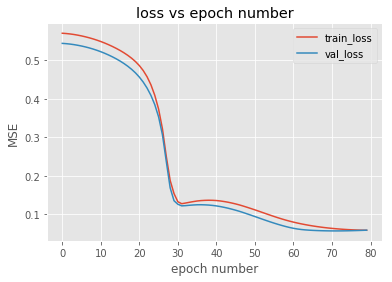

314

(25434, 28)

(25434, 1)

Loss: 

0.340767740042

 Accuracy: 

0.46656050955414013

Loss: 

0.31575956476

 Accuracy: 

0.5047770700636943

Loss: 

0.272890159359

 Accuracy: 

0.5843949044585988

Loss: 

0.215594648882

 Accuracy: 

0.6767515923566879

Loss: 

0.170052289796

 Accuracy: 

0.7340764331210191

Loss: 

0.153763444976

 Accuracy: 

0.75

Loss: 

0.151779899164

 Accuracy: 

0.7404458598726115

Loss: 

0.154220989253

 Accuracy: 

0.7308917197452229

Loss: 

0.15789933827

 Accuracy: 

0.7181528662420382

Loss: 

0.162012787623

 Accuracy: 

0.695859872611465

Loss: 

0.166102920761

 Accuracy: 

0.6863057324840764

Loss: 

0.169940149232

 Accuracy: 

0.6799363057324841

Loss: 

0.173420267266

 Accuracy: 

0.6656050955414012

Loss: 

0.176615284686

 Accuracy: 

0.6592356687898089

Loss: 

0.179516672356

 Accuracy: 

0.6496815286624203

Loss: 

0.18201680731

 Accuracy: 

0.6449044585987261

Loss: 

0.18405023677

 Accuracy: 

0.6449044585987261

Loss: 

0.185589508673

 Accuracy: 

0.64171974522293

Loss: 

0.186701785858

 Accuracy: 

0.6353503184713376

Loss: 

0.187352547308

 Accuracy: 

0.6401273885350318

Loss: 

0.187504969638

 Accuracy: 

0.6401273885350318

Loss: 

0.18723577164

 Accuracy: 

0.6401273885350318

Loss: 

0.18647013715

 Accuracy: 

0.643312101910828

Loss: 

0.185240106168

 Accuracy: 

0.6464968152866242

Loss: 

0.183500400031

 Accuracy: 

0.6528662420382165

Loss: 

0.181264412091

 Accuracy: 

0.6592356687898089

Loss: 

0.178556630505

 Accuracy: 

0.6592356687898089

Loss: 

0.175535504891

 Accuracy: 

0.6703821656050956

Loss: 

0.172114885637

 Accuracy: 

0.6831210191082803

Loss: 

0.1683203086

 Accuracy: 

0.6942675159235668

Loss: 

0.164188647789

 Accuracy: 

0.7070063694267515

Loss: 

0.159767408139

 Accuracy: 

0.7261146496815286

Loss: 

0.155124491669

 Accuracy: 

0.7356687898089171

Loss: 

0.150307889765

 Accuracy: 

0.7468152866242038

Loss: 

0.145401472232

 Accuracy: 

0.7595541401273885

Loss: 

0.140299500433

 Accuracy: 

0.7738853503184714

Loss: 

0.135157948181

 Accuracy: 

0.7898089171974523

Loss: 

0.130026978408

 Accuracy: 

0.804140127388535

Loss: 

0.124924090307

 Accuracy: 

0.8248407643312102

Loss: 

0.119906557429

 Accuracy: 

0.8328025477707006

Loss: 

0.115033808091

 Accuracy: 

0.8519108280254777

Loss: 

0.110218940588

 Accuracy: 

0.8535031847133758

Loss: 

0.105584511788

 Accuracy: 

0.8662420382165605

Loss: 

0.101171919077

 Accuracy: 

0.8694267515923567

Loss: 

0.0970044453662

 Accuracy: 

0.8678343949044586

Loss: 

0.0930984562497

 Accuracy: 

0.8726114649681529

Loss: 

0.0895127609604

 Accuracy: 

0.8805732484076433

Loss: 

0.086197414299

 Accuracy: 

0.8869426751592356

Loss: 

0.0831688928722

 Accuracy: 

0.893312101910828

Loss: 

0.0804290763906

 Accuracy: 

0.893312101910828

Loss: 

0.0779752899818

 Accuracy: 

0.8980891719745223

Loss: 

0.075803349965

 Accuracy: 

0.910828025477707

Loss: 

0.073910771946

 Accuracy: 

0.9187898089171974

Loss: 

0.072339285844

 Accuracy: 

0.9203821656050956

Loss: 

0.0710495779473

 Accuracy: 

0.9171974522292994

Loss: 

0.0700006621256

 Accuracy: 

0.9203821656050956

Loss: 

0.0691546229705

 Accuracy: 

0.9219745222929936

Loss: 

0.0684735934137

 Accuracy: 

0.928343949044586

Loss: 

0.0679273076681

 Accuracy: 

0.9299363057324841

Loss: 

0.0675037773127

 Accuracy: 

0.9251592356687898

Loss: 

0.0671920502984

 Accuracy: 

0.9251592356687898

Loss: 

0.0669857457705

 Accuracy: 

0.9235668789808917

Loss: 

0.0668784371931

 Accuracy: 

0.9235668789808917

Loss: 

0.0668673573113

 Accuracy: 

0.9219745222929936

Loss: 

0.0669456694471

 Accuracy: 

0.9219745222929936

Loss: 

0.0671034843398

 Accuracy: 

0.9203821656050956

Loss: 

0.067332645891

 Accuracy: 

0.9203821656050956

Loss: 

0.0676324039875

 Accuracy: 

0.9203821656050956

Loss: 

0.0679912365802

 Accuracy: 

0.9187898089171974

Loss: 

0.0684021621486

 Accuracy: 

0.9187898089171974

Loss: 

0.0688556900852

 Accuracy: 

0.9171974522292994

Loss: 

0.0693443620541

 Accuracy: 

0.9171974522292994

Loss: 

0.069861605163

 Accuracy: 

0.9156050955414012

Loss: 

0.0704026862225

 Accuracy: 

0.9156050955414012

Loss: 

0.0709593715401

 Accuracy: 

0.9156050955414012

Loss: 

0.0715316885816

 Accuracy: 

0.9124203821656051

Loss: 

0.072109161574

 Accuracy: 

0.9124203821656051

Loss: 

0.0726830389676

 Accuracy: 

0.9124203821656051

Loss: 

0.0732491473751

 Accuracy: 

0.9092356687898089

Loss: 

0.0738076105726

 Accuracy: 

0.9076433121019108


Validation dataset evaluation:

Loss: 

0.0446247773034

Accuracy: 

0.9358974358974359

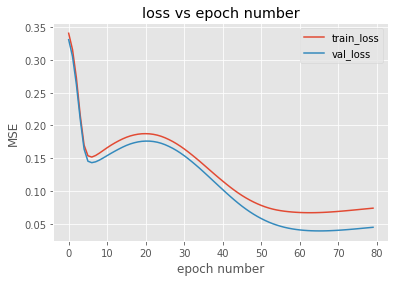

314

(25434, 28)

(25434, 1)

Loss: 

0.293336186171

 Accuracy: 

0.5493630573248408

Loss: 

0.270296860338

 Accuracy: 

0.5828025477707006

Loss: 

0.2387961687

 Accuracy: 

0.6098726114649682

Loss: 

0.209496673744

 Accuracy: 

0.6624203821656051

Loss: 

0.192061044494

 Accuracy: 

0.6863057324840764

Loss: 

0.182619396226

 Accuracy: 

0.7038216560509554

Loss: 

0.17744556796

 Accuracy: 

0.7054140127388535

Loss: 

0.1744803134

 Accuracy: 

0.6942675159235668

Loss: 

0.173377695765

 Accuracy: 

0.6942675159235668

Loss: 

0.174373766311

 Accuracy: 

0.6863057324840764

Loss: 

0.176314209371

 Accuracy: 

0.6815286624203821

Loss: 

0.178464404588

 Accuracy: 

0.6703821656050956

Loss: 

0.18046411242

 Accuracy: 

0.6624203821656051

Loss: 

0.182220826647

 Accuracy: 

0.6592356687898089

Loss: 

0.18360347993

 Accuracy: 

0.6560509554140127

Loss: 

0.184566860935

 Accuracy: 

0.6528662420382165

Loss: 

0.185096294302

 Accuracy: 

0.6512738853503185

Loss: 

0.184981991998

 Accuracy: 

0.6512738853503185

Loss: 

0.184364715241

 Accuracy: 

0.6576433121019108

Loss: 

0.18332747121

 Accuracy: 

0.6592356687898089

Loss: 

0.181848645311

 Accuracy: 

0.6640127388535032

Loss: 

0.179802700111

 Accuracy: 

0.6687898089171974

Loss: 

0.177287723523

 Accuracy: 

0.6767515923566879

Loss: 

0.174269943874

 Accuracy: 

0.6831210191082803

Loss: 

0.170632921811

 Accuracy: 

0.6910828025477707

Loss: 

0.166605549911

 Accuracy: 

0.7085987261146497

Loss: 

0.162167032788

 Accuracy: 

0.7308917197452229

Loss: 

0.157273577182

 Accuracy: 

0.7420382165605095

Loss: 

0.152025130212

 Accuracy: 

0.7547770700636943

Loss: 

0.146398161197

 Accuracy: 

0.767515923566879

Loss: 

0.140611420227

 Accuracy: 

0.7786624203821656

Loss: 

0.134692560213

 Accuracy: 

0.7898089171974523

Loss: 

0.128604091651

 Accuracy: 

0.8057324840764332

Loss: 

0.122493320362

 Accuracy: 

0.8264331210191083

Loss: 

0.11645944159

 Accuracy: 

0.8407643312101911

Loss: 

0.110667333857

 Accuracy: 

0.8614649681528662

Loss: 

0.104982791841

 Accuracy: 

0.8694267515923567

Loss: 

0.0995006539298

 Accuracy: 

0.8853503184713376

Loss: 

0.0942890202

 Accuracy: 

0.8964968152866242

Loss: 

0.0894123580962

 Accuracy: 

0.9012738853503185

Loss: 

0.0848599766097

 Accuracy: 

0.910828025477707

Loss: 

0.0808063375072

 Accuracy: 

0.9156050955414012

Loss: 

0.0770995099053

 Accuracy: 

0.9156050955414012

Loss: 

0.0737333983821

 Accuracy: 

0.9235668789808917

Loss: 

0.0706731809722

 Accuracy: 

0.9235668789808917

Loss: 

0.0679331275712

 Accuracy: 

0.9219745222929936

Loss: 

0.0654778849882

 Accuracy: 

0.9267515923566879

Loss: 

0.0633194024071

 Accuracy: 

0.9235668789808917

Loss: 

0.0614782420989

 Accuracy: 

0.9251592356687898

Loss: 

0.0599986433242

 Accuracy: 

0.9267515923566879

Loss: 

0.0588882934538

 Accuracy: 

0.928343949044586

Loss: 

0.0581394073238

 Accuracy: 

0.9251592356687898

Loss: 

0.0577091731474

 Accuracy: 

0.9235668789808917

Loss: 

0.0575411712512

 Accuracy: 

0.9251592356687898

Loss: 

0.0575781397312

 Accuracy: 

0.9267515923566879

Loss: 

0.0577873100769

 Accuracy: 

0.9251592356687898

Loss: 

0.0581321253033

 Accuracy: 

0.9251592356687898

Loss: 

0.0586070431727

 Accuracy: 

0.9235668789808917

Loss: 

0.0592416743721

 Accuracy: 

0.9203821656050956

Loss: 

0.0600987095823

 Accuracy: 

0.9187898089171974

Loss: 

0.0612245246158

 Accuracy: 

0.9187898089171974

Loss: 

0.0625655667769

 Accuracy: 

0.9124203821656051

Loss: 

0.0639545574901

 Accuracy: 

0.9124203821656051

Loss: 

0.0652434439817

 Accuracy: 

0.9124203821656051

Loss: 

0.0663645157087

 Accuracy: 

0.9124203821656051

Loss: 

0.0673155784565

 Accuracy: 

0.9124203821656051

Loss: 

0.0680953675555

 Accuracy: 

0.9124203821656051

Loss: 

0.0687537266027

 Accuracy: 

0.910828025477707

Loss: 

0.0693123565492

 Accuracy: 

0.910828025477707

Loss: 

0.0697824468212

 Accuracy: 

0.910828025477707

Loss: 

0.0701595196733

 Accuracy: 

0.910828025477707

Loss: 

0.070458081408

 Accuracy: 

0.910828025477707

Loss: 

0.0706852164357

 Accuracy: 

0.910828025477707

Loss: 

0.0708398960182

 Accuracy: 

0.910828025477707

Loss: 

0.0709331817163

 Accuracy: 

0.910828025477707

Loss: 

0.0709416597062

 Accuracy: 

0.910828025477707

Loss: 

0.0708771188113

 Accuracy: 

0.9092356687898089

Loss: 

0.0707270941932

 Accuracy: 

0.9092356687898089

Loss: 

0.0705033321379

 Accuracy: 

0.9092356687898089

Loss: 

0.0701727896426

 Accuracy: 

0.910828025477707


Validation dataset evaluation:

Loss: 

0.0611909506202

Accuracy: 

0.9294871794871795

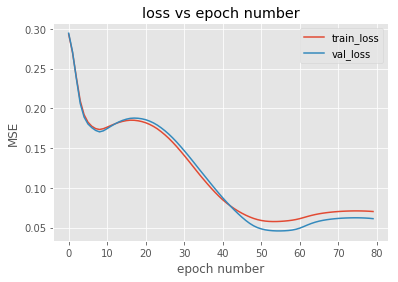

In [59]:
for k, validation_frauds in enumerate(kfold_split_frauds):
    #print(k_fold_split_array)
    #losowanie dobrych transakcji

    #Get train frauds from train&validation frauds
    train_frauds = kfold_split_frauds.copy()
    train_frauds.pop(k)
    train_frauds = np.concatenate(train_frauds)
    print(len(train_frauds))
    
    validation_normals = kfold_split_normals[k]
    np.random.shuffle(normal_train)
    train_normals = normal_train[:train_frauds.shape[0]*EPOCHS,:]
    
    train = np.concatenate([train_frauds, train_normals])
    
    #train = np.concatenate([train,normal_indices_split_array])
    
    x_train = train[:, :-1]
    y_train = train[:, -1:]
    

    validation = np.concatenate([validation_frauds,validation_normals])
    np.random.shuffle(validation)

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

        # 653
    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation, distinct=1)

    print("\n", '='*80)
    print("\nValidation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    plot_loss(model.epochs, model.training_history, model.validation_history)
    models.append(model)


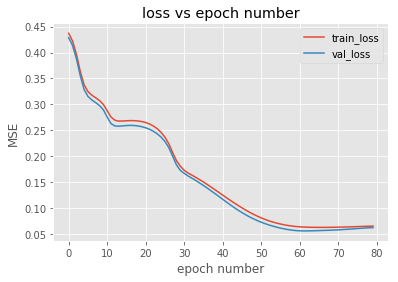

In [60]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [61]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:

(784, 28)

(784, 1)

Loss: 

0.227473995556

 Accuracy: 

0.6352040816326531

Loss: 

0.220422420295

 Accuracy: 

0.639030612244898

Loss: 

0.211504174186

 Accuracy: 

0.6505102040816326

Loss: 

0.201827856728

 Accuracy: 

0.6607142857142857

Loss: 

0.192112567396

 Accuracy: 

0.6632653061224489

Loss: 

0.182907360583

 Accuracy: 

0.6811224489795918

Loss: 

0.174738677158

 Accuracy: 

0.6849489795918368

Loss: 

0.168300757545

 Accuracy: 

0.6938775510204082

Loss: 

0.164149582746

 Accuracy: 

0.6964285714285714

Loss: 

0.161946208444

 Accuracy: 

0.7040816326530612

Loss: 

0.160960148288

 Accuracy: 

0.701530612244898

Loss: 

0.160487210415

 Accuracy: 

0.7028061224489796

Loss: 

0.160131428915

 Accuracy: 

0.7053571428571429

Loss: 

0.159700673528

 Accuracy: 

0.7053571428571429

Loss: 

0.159084111517

 Accuracy: 

0.7091836734693877

Loss: 

0.158208168536

 Accuracy: 

0.7091836734693877

Loss: 

0.157022675331

 Accuracy: 

0.7130102040816326

Loss: 

0.155494597846

 Accuracy: 

0.7130102040816326

Loss: 

0.153604287447

 Accuracy: 

0.7206632653061225

Loss: 

0.151343016094

 Accuracy: 

0.7257653061224489

Loss: 

0.148711442548

 Accuracy: 

0.7385204081632653

Loss: 

0.145718793851

 Accuracy: 

0.7512755102040817

Loss: 

0.142382522044

 Accuracy: 

0.7653061224489796

Loss: 

0.138728235052

 Accuracy: 

0.7742346938775511

Loss: 

0.13478948414

 Accuracy: 

0.7857142857142857

Loss: 

0.130607100174

 Accuracy: 

0.7959183673469388

Loss: 

0.126227798962

 Accuracy: 

0.8176020408163265

Loss: 

0.121702131465

 Accuracy: 

0.826530612244898

Loss: 

0.117082231572

 Accuracy: 

0.8380102040816326

Loss: 

0.112419996976

 Accuracy: 

0.8545918367346939

Loss: 

0.107765881105

 Accuracy: 

0.8775510204081632

Loss: 

0.103168153854

 Accuracy: 

0.8801020408163265

Loss: 

0.0986723480419

 Accuracy: 

0.8928571428571429

Loss: 

0.0943206632695

 Accuracy: 

0.8979591836734694

Loss: 

0.090151409235

 Accuracy: 

0.9119897959183674

Loss: 

0.0861983964484

 Accuracy: 

0.9183673469387755

Loss: 

0.0824903813027

 Accuracy: 

0.9221938775510204

Loss: 

0.0790505004623

 Accuracy: 

0.9272959183673469

Loss: 

0.0758957130635

 Accuracy: 

0.9272959183673469

Loss: 

0.0730363007787

 Accuracy: 

0.9272959183673469

Loss: 

0.0704755635345

 Accuracy: 

0.9285714285714286

Loss: 

0.0682098284496

 Accuracy: 

0.9247448979591837

Loss: 

0.0662289992657

 Accuracy: 

0.923469387755102

Loss: 

0.0645176327738

 Accuracy: 

0.9285714285714286

Loss: 

0.0630564961467

 Accuracy: 

0.9336734693877551

Loss: 

0.061824263987

 Accuracy: 

0.9336734693877551

Loss: 

0.0607990413164

 Accuracy: 

0.9336734693877551

Loss: 

0.0599594900945

 Accuracy: 

0.9323979591836735

Loss: 

0.0592854952018

 Accuracy: 

0.9323979591836735

Loss: 

0.0587585098264

 Accuracy: 

0.9323979591836735

Loss: 

0.0583617221425

 Accuracy: 

0.9311224489795918

Loss: 

0.0580802362331

 Accuracy: 

0.9285714285714286

Loss: 

0.057901346902

 Accuracy: 

0.9272959183673469

Loss: 

0.0578149088032

 Accuracy: 

0.9285714285714286

Loss: 

0.0578137473905

 Accuracy: 

0.9298469387755102

Loss: 

0.0578937148729

 Accuracy: 

0.9285714285714286

Loss: 

0.058052797627

 Accuracy: 

0.9285714285714286

Loss: 

0.0582885897168

 Accuracy: 

0.9285714285714286

Loss: 

0.0585941215499

 Accuracy: 

0.9272959183673469

Loss: 

0.0589535400701

 Accuracy: 

0.9272959183673469

Loss: 

0.0593404954164

 Accuracy: 

0.9260204081632653

Loss: 

0.0597211653428

 Accuracy: 

0.9260204081632653

Loss: 

0.0600607422429

 Accuracy: 

0.9260204081632653

Loss: 

0.06032994172

 Accuracy: 

0.9260204081632653

Loss: 

0.0605090410661

 Accuracy: 

0.9247448979591837

Loss: 

0.0605893570684

 Accuracy: 

0.9247448979591837

Loss: 

0.0605733846926

 Accuracy: 

0.9260204081632653

Loss: 

0.0604745667331

 Accuracy: 

0.9260204081632653

Loss: 

0.0603159805619

 Accuracy: 

0.9260204081632653

Loss: 

0.0601267557712

 Accuracy: 

0.9260204081632653

Loss: 

0.0599358683741

 Accuracy: 

0.9272959183673469

Loss: 

0.0597652664343

 Accuracy: 

0.9285714285714286

Loss: 

0.0596258748009

 Accuracy: 

0.9285714285714286

Loss: 

0.0595181795805

 Accuracy: 

0.9285714285714286

Loss: 

0.059436212792

 Accuracy: 

0.9285714285714286

Loss: 

0.0593719273697

 Accuracy: 

0.9285714285714286

Loss: 

0.0593180391317

 Accuracy: 

0.9298469387755102

Loss: 

0.0592691293196

 Accuracy: 

0.9311224489795918

Loss: 

0.0592217340043

 Accuracy: 

0.9311224489795918

Loss: 

0.0591738673691

 Accuracy: 

0.9311224489795918

In [66]:
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

(56962, 28)

(56962, 1)

Loss: 

0.00759186458807

Accuracy: 

0.9917664407850848


Precision: 0.41624365482233505

Recall: 0.82

F-score: 0.5521885521885522

             actual 1  actual 0
predicted 1        82       115
predicted 0        18     56747

  0%|                                                   | 0/21 [00:00<?, ?it/s]

  5%|██                                         | 1/21 [00:08<02:42,  8.13s/it]

 10%|████                                       | 2/21 [00:17<02:45,  8.72s/it]

 14%|██████▏                                    | 3/21 [00:24<02:27,  8.19s/it]

 19%|████████▏                                  | 4/21 [00:30<02:07,  7.53s/it]

 24%|██████████▏                                | 5/21 [00:35<01:52,  7.02s/it]

 29%|████████████▎                              | 6/21 [00:40<01:41,  6.76s/it]

 33%|██████████████▎                            | 7/21 [00:48<01:37,  6.98s/it]

 38%|████████████████▍                          | 8/21 [00:57<01:33,  7.20s/it]

 43%|██████████████████▍                        | 9/21 [01:06<01:29,  7.43s/it]

 48%|████████████████████                      | 10/21 [01:13<01:21,  7.39s/it]

 52%|██████████████████████                    | 11/21 [01:21<01:13,  7.39s/it]

 57%|████████████████████████                  | 12/21 [01:28<01:06,  7.35s/it]

 62%|██████████████████████████                | 13/21 [01:36<00:59,  7.42s/it]

 67%|████████████████████████████              | 14/21 [01:42<00:51,  7.35s/it]

 71%|██████████████████████████████            | 15/21 [01:49<00:43,  7.27s/it]

 76%|████████████████████████████████          | 16/21 [01:54<00:35,  7.15s/it]

 81%|██████████████████████████████████        | 17/21 [02:00<00:28,  7.07s/it]

 86%|████████████████████████████████████      | 18/21 [02:05<00:20,  6.98s/it]

 90%|██████████████████████████████████████    | 19/21 [02:12<00:13,  6.95s/it]

 95%|████████████████████████████████████████  | 20/21 [02:17<00:06,  6.88s/it]

100%|██████████████████████████████████████████| 21/21 [02:23<00:00,  6.83s/it]

No handles with labels found to put in legend.

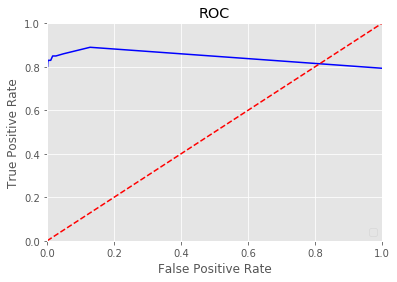

In [67]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)

